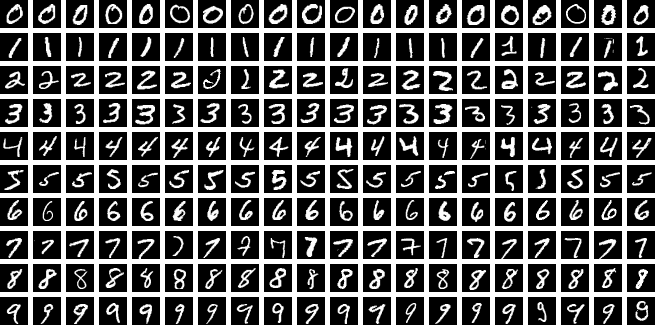

# Import library yang diperlukan

In [ ]:
# Import library
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Library untuk mendapatkan ringkasan informasi tentang model (Terutama parameter)
from torchsummary import summary

import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

# Import dan proses data

In [ ]:
# Import dataset (sudah tersedia jika menggunakan Google Colab)
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')
data

array([[6., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [7., 0., 0., ..., 0., 0., 0.],
       ...,
       [2., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Ekstraksi label (nomor angka yg benar) dan hapus label dari dataset yang akan digunakan
labels = data[:, 0] # Mengambil kolom pertama
data = data[:, 1:] # Mengambil kolom kedua hingga terakhir

In [ ]:
# Normalisasi data agar dalam range 0 - 1 (skala minmax)
dataNorm = data / np.max(data)

In [ ]:
# Ubah bentuk data menjadi 2D (Gambar)
dataNorm = dataNorm.reshape(dataNorm.shape[0], 1, 28, 28)
dataNorm.shape

(20000, 1, 28, 28)

# Split data training dan test dengan DataLoader

In [ ]:
# Ubah data & label jadi tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

In [ ]:
# Split data training dan test
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=0.1, random_state=42)

In [ ]:
# Ubah menjadi dataset Pytorch
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

In [ ]:
# Ubah jadi objek Dataloader
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=True, drop_last=True)

In [ ]:
# Cek ukuran data (jumlah image, jumlah channel, lebar image, tinggi image)
train_loader.dataset.tensors[0].shape

torch.Size([18000, 1, 28, 28])

# Model Deep Learning

In [ ]:
def createTheMNISTNet(printtoggle=False):
    class mnistNet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()

            ### Convolution Layer
            self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=1)
            self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=1)

            # Tentukan fungsi pooling
            self.pool = nn.MaxPool2d(2)

            # Hitung jumlah unit flattened secara dinamis dengan menggunakan tensor dummy
            with torch.no_grad():
                dummy = torch.zeros(1, 1, 28, 28)
                dummy = F.relu(self.conv1(dummy))
                dummy = self.pool(dummy)
                dummy = F.relu(self.conv2(dummy))
                dummy = self.pool(dummy)
                self.nUnits = dummy.numel() // dummy.size(0)  # Total fitur per sampel

            ### Fully-connected (FC) layer
            self.fcl = nn.Linear(self.nUnits, 50)

            ### Output layer
            self.out = nn.Linear(50, 10)

            # Toggle untuk mencetak ukuran tensor saat forward propagation
            self.print = printtoggle

        def forward(self, x):
            if self.print:
                print(f'Input: {x.shape}')

            x = F.relu(self.conv1(x))
            x = self.pool(x)
            if self.print:
                print(f'Layer conv1/pool1: {x.shape}')

            x = F.relu(self.conv2(x))
            x = self.pool(x)
            if self.print:
                print(f'Layer conv2/pool2: {x.shape}')

            # Flatten semua fitur kecuali batch dimension
            x = x.view(x.size(0), -1)
            if self.print:
                print(f'Vectorize: {x.shape}')

            x = F.relu(self.fcl(x))
            x = self.out(x)

            if self.print:
                print(f'Layer out: {x.shape}')

            return x

    net = mnistNet(printtoggle)

    # Loss function
    lossFunction = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    return net, lossFunction, optimizer

In [ ]:
net, lossfunction, optimizer = createTheMNISTNet(True)

X, y = next(iter(train_loader))
yHat = net(X)

# Mengecek ukuran output dan variabel target
print('')
print(f'Ukuran output: {yHat.shape}')
print(f'Ukuran target: {y.shape}')

# Hitung loss
loss = lossfunction(yHat, y)
print(f'Loss: {loss}')
print('')
print('Loss: ')
print(loss)

Input: torch.Size([32, 1, 28, 28])
Layer conv1/pool1: torch.Size([32, 10, 13, 13])
Layer conv2/pool2: torch.Size([32, 20, 5, 5])
Vectorize: torch.Size([32, 500])
Layer out: torch.Size([32, 10])

Ukuran output: torch.Size([32, 10])
Ukuran target: torch.Size([32])
Loss: 2.338735342025757

Loss: 
tensor(2.3387, grad_fn=<NllLossBackward0>)


In [ ]:
summary(net, (1, 28, 28))

Input: torch.Size([2, 1, 28, 28])
Layer conv1/pool1: torch.Size([2, 10, 13, 13])
Layer conv2/pool2: torch.Size([2, 20, 5, 5])
Vectorize: torch.Size([2, 500])
Layer out: torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
         MaxPool2d-2           [-1, 10, 13, 13]               0
            Conv2d-3           [-1, 20, 11, 11]           5,020
         MaxPool2d-4             [-1, 20, 5, 5]               0
            Linear-5                   [-1, 50]          25,050
            Linear-6                   [-1, 10]             510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.12
Estimated Total Size (MB): 0.21
------------------------------------------------

# Training model

In [ ]:
def function2trainTheModel():

  jumlahEpochs = 10 # Jumlah epochs

  # Membuat model baru
  net, lossfunction, optimizer = createTheMNISTNet()

  # Inisialisasi loss
  losses = torch.zeros(jumlahEpochs)
  trainAcc = []
  testAcc = []


  # Membuat loop sebanyak jumlah epochs
  for epochs in range(jumlahEpochs):
      # Membuat loop sebanyak jumlah batch data training
      net.train()

      batchAcc = []
      batchLoss = []

      for X, y in train_loader:
          # Forward pass dan Loss
          yHat = net(X)
          loss = lossfunction(yHat, y)

          # Back propagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Loss dari batch ni
          batchLoss.append(loss.item())

          ## Menghitung akurasi dimana Boolean (false/true)
          matches = torch.argmax(yHat, axis=1) == y
          # Mengubah menjadi angka (0/1)
          matchesNumeric = matches.float()
          # Persentase
          accuracyPct = 100 * torch.mean(matchesNumeric)
          # Tambahkan ke dalam list akurasi
          batchAcc.append(accuracyPct)
          # Loop batch terakhir

      # Rata2 akurasi pelatihan semua batch
      trainAcc.append(np.mean(batchAcc))

      # Rata2 loss semua batch
      losses[epochs] = np.mean(batchLoss)

      # Uji akurasi
      net.eval()
      # Ekstrak X dan y dari dataloader test

      X_test, y_test = next(iter(test_loader))

      with torch.no_grad():
          yHat = net(X_test)

      # Akurasi pelatihan
      testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y_test).float()))

      # Akhir dari epoch

  # Output fungsi
  return trainAcc, testAcc, losses, net

In [ ]:
trainAcc, testAcc, losses, net = function2trainTheModel()

# Visualisasi Hasil

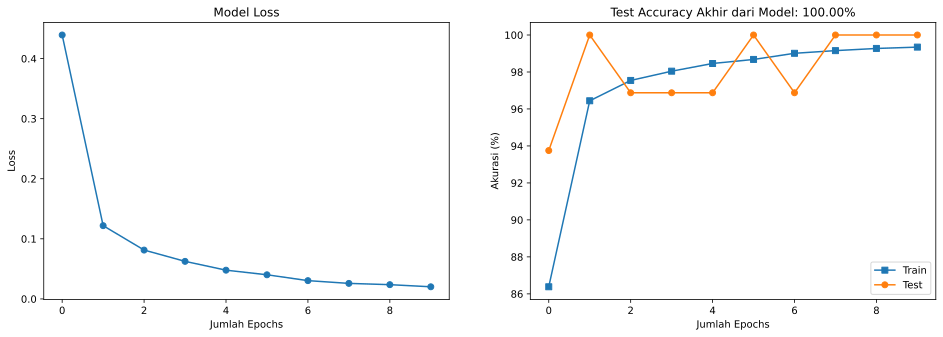

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))

ax[0].plot(losses, 'o-')
ax[0].set_xlabel('Jumlah Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc, 's-', label='Train')
ax[1].plot(testAcc, 'o-', label='Test')
ax[1].set_xlabel('Jumlah Epochs')
ax[1].set_ylabel('Akurasi (%)')
ax[1].set_title(f'Test Accuracy Akhir dari Model: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()